In [ ]:
from random import seed
import pandas as pd
import numpy as np
seed(1)

folder_path = ''

train_folder = folder_path + '/train'

def get_data_for_week(week):
    week_input = pd.read_csv(f'{train_folder}/input_2023_w{week}.csv')
    week_output = pd.read_csv(f'{train_folder}/output_2023_w{week}.csv')
    return week_input, week_output

def get_sup_data():
    sup_data = pd.read_csv(folder_path + '/supplementary_data.csv')
    return sup_data


weeks = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']

sup_data = get_sup_data()

weeks_df_arr_input = []
weeks_df_arr_output = []
for week in weeks:
    week_input1, week_output1 = get_data_for_week(week)
    weeks_df_arr_input.append(week_input1)
    weeks_df_arr_output.append(week_output1)

week_input = pd.concat(weeks_df_arr_input)
week_output = pd.concat(weeks_df_arr_output)

print(f"all weeks input.shape: {week_input.shape}")
print(f"all weeks output.shape: {week_output.shape}")

def make_game_play_id(df):
    return df['game_id'].astype(str) + '_' + df['play_id'].astype(str)

sup_data['game_play_id'] = make_game_play_id(sup_data)
week_input['game_play_id'] = make_game_play_id(week_input)
week_output['game_play_id'] = make_game_play_id(week_output)

sup_data.drop(columns=['game_id'], inplace=True)
sup_data.drop(columns=['play_id'], inplace=True)

week_input.drop(columns=['game_id'], inplace=True)
week_input.drop(columns=['play_id'], inplace=True)

week_output.drop(columns=['game_id'], inplace=True)
week_output.drop(columns=['play_id'], inplace=True)

/var/folders/5w/wqg3d8mj5xbb7jj6cc1hx8vc0000gn/T/ipykernel_67285/409864136.py:14: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  sup_data = pd.read_csv('/Users/anirudhkaranam/Downloads/114239_nfl_competition_files_published_analytics_final/supplementary_data.csv')


all_weeks_input.shape: (4880579, 23)
all_weeks_output.shape: (562936, 6)


In [ ]:
input_features = ['nfl_id', 'play_direction', 'player_name',
       'player_position', 'player_side', 'player_role', 'ball_land_x', 'ball_land_y',
       'game_play_id']

week_input = week_input[input_features]
week_input = week_input.drop_duplicates(subset=['game_play_id', 'nfl_id'])

In [16]:
print(f"week_input.shape: {week_input.shape}")
print(f"week_output.shape: {week_output.shape}")

week_input.shape: (173150, 9)
week_output.shape: (562936, 5)


In [ ]:
merged = pd.merge(week_output, week_input, on=['game_play_id', 'nfl_id'], how='left')
merged.head()

print(f"merged.shape: {merged.shape}")

merged.shape: (562936, 12)


In [43]:
merged_with_sup = pd.merge(merged, sup_data, on='game_play_id', how='left')
print(f"merged_with_sup.shape: {merged_with_sup.shape}")

merged_with_sup.shape: (562936, 51)


--- Analyzing Play ID: 2023111902_745 (Incompletion) ---


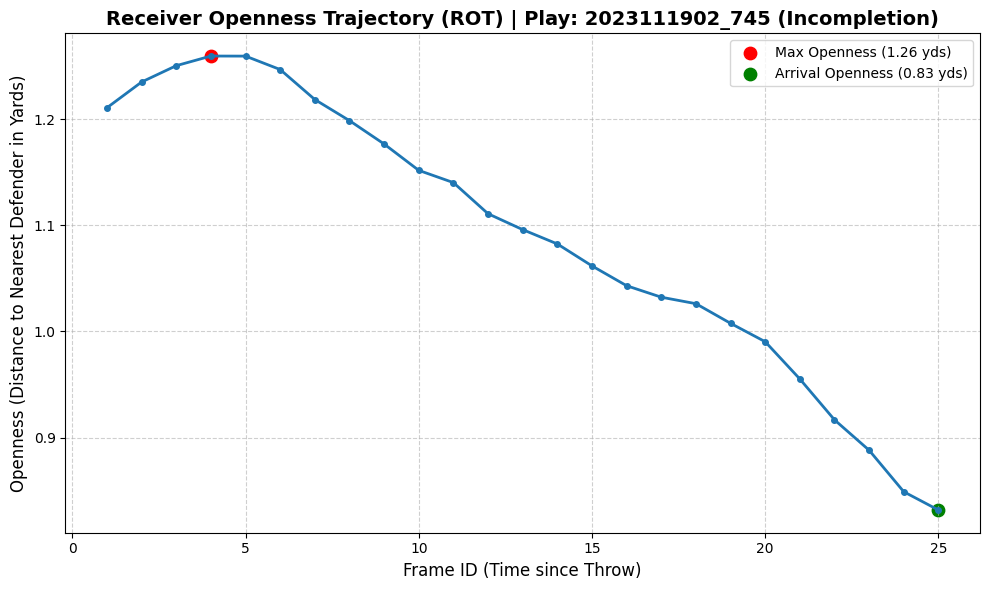


Plot generated successfully.
--- Analyzing Play ID: 2023091008_888 (Completion) ---


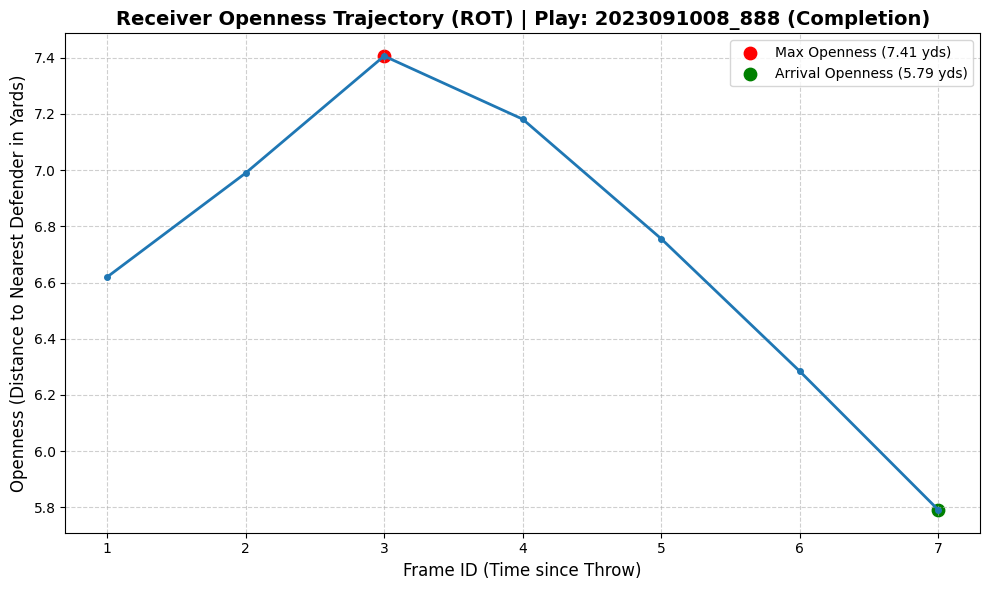


Plot generated successfully.
--- Analyzing Play ID: 2024010705_1715 (Incompletion) ---


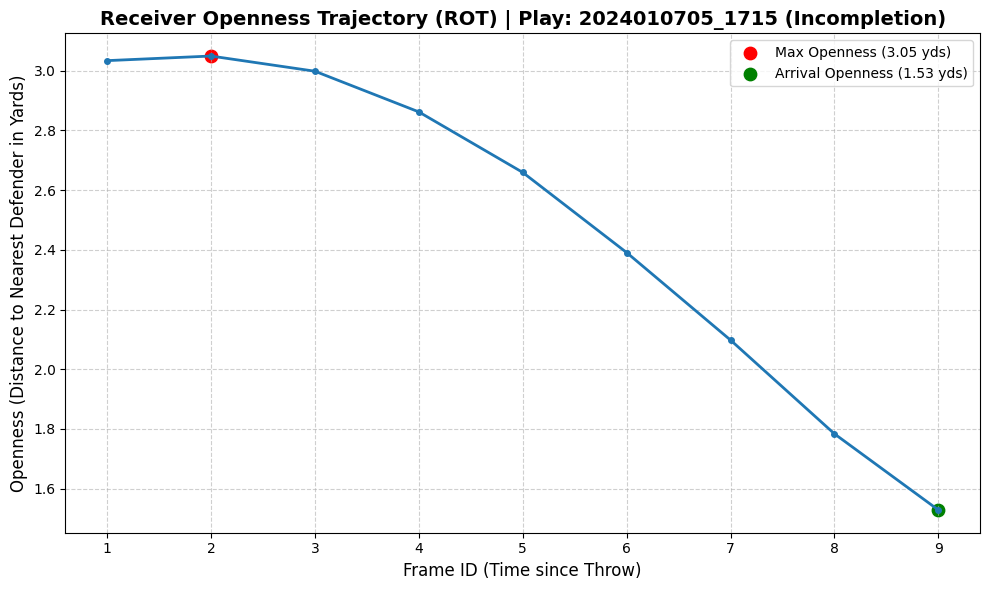


Plot generated successfully.
--- Analyzing Play ID: 2023103000_2070 (Completion) ---


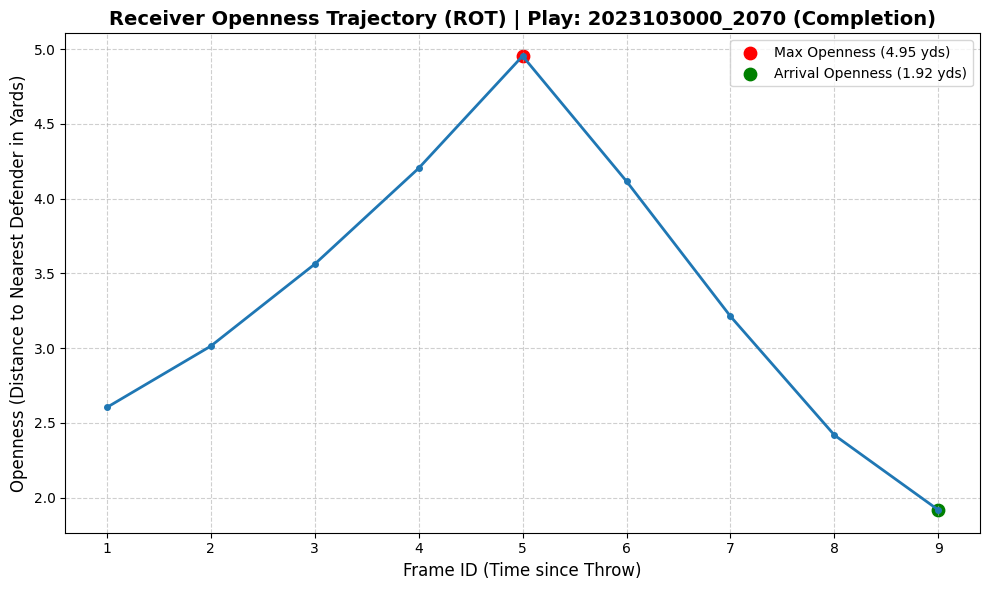


Plot generated successfully.
--- Analyzing Play ID: 2023110600_2558 (Completion) ---
Error: Targeted Receiver or Defensive Coverage data not found for this play.
--- Analyzing Play ID: 2023120309_3867 (Completion) ---
Error: Targeted Receiver or Defensive Coverage data not found for this play.
--- Analyzing Play ID: 2023122502_274 (Interception) ---


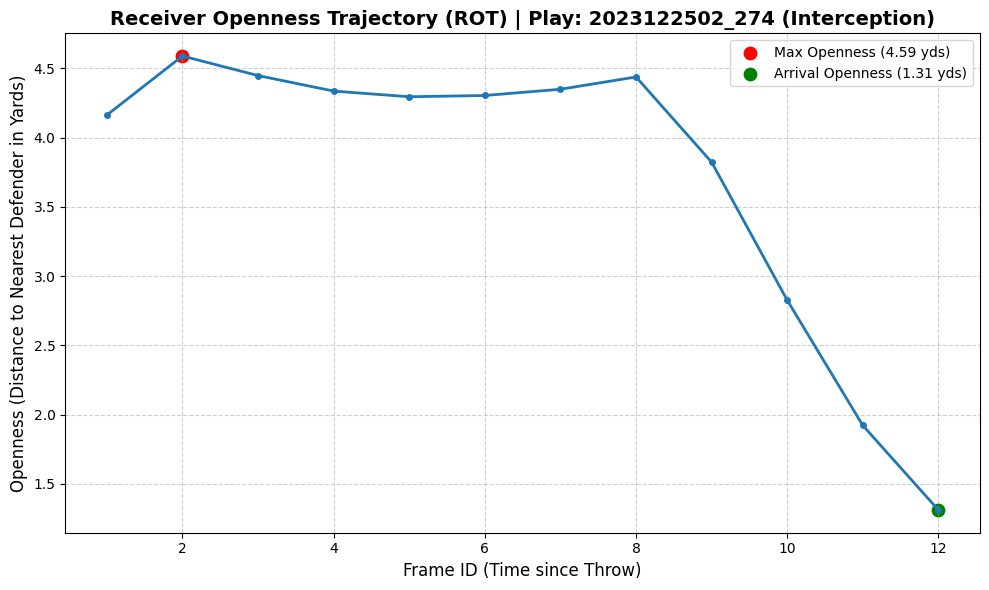


Plot generated successfully.
--- Analyzing Play ID: 2023122800_1649 (Completion) ---


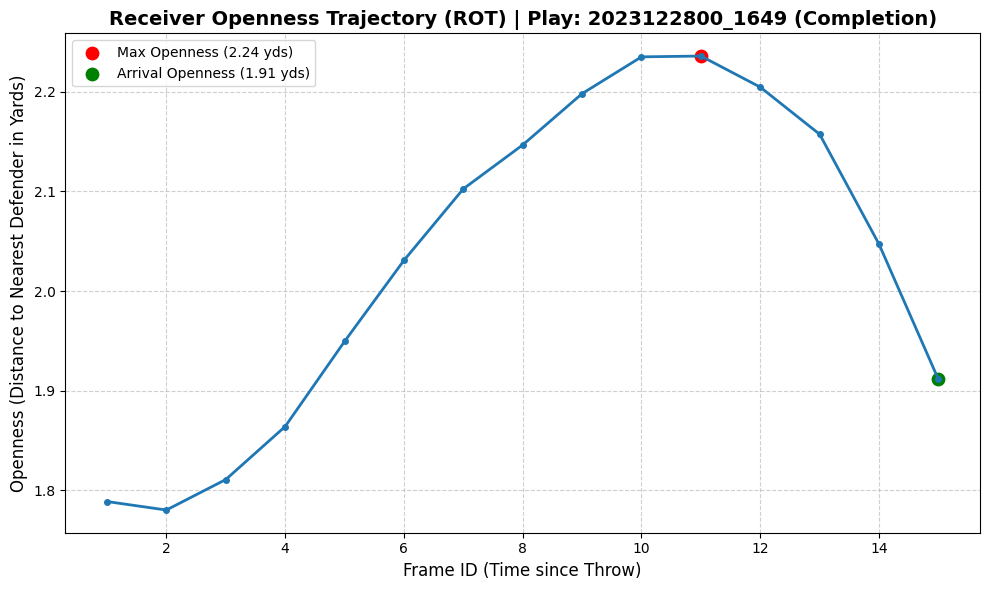


Plot generated successfully.
--- Analyzing Play ID: 2023090700_2364 (Interception) ---


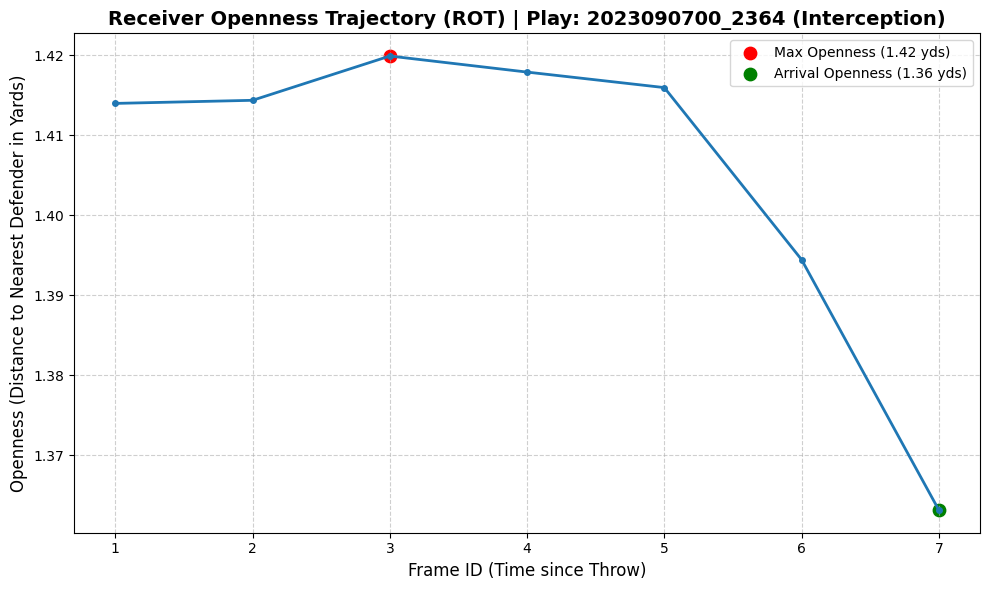


Plot generated successfully.
--- Analyzing Play ID: 2023121706_3345 (Completion) ---


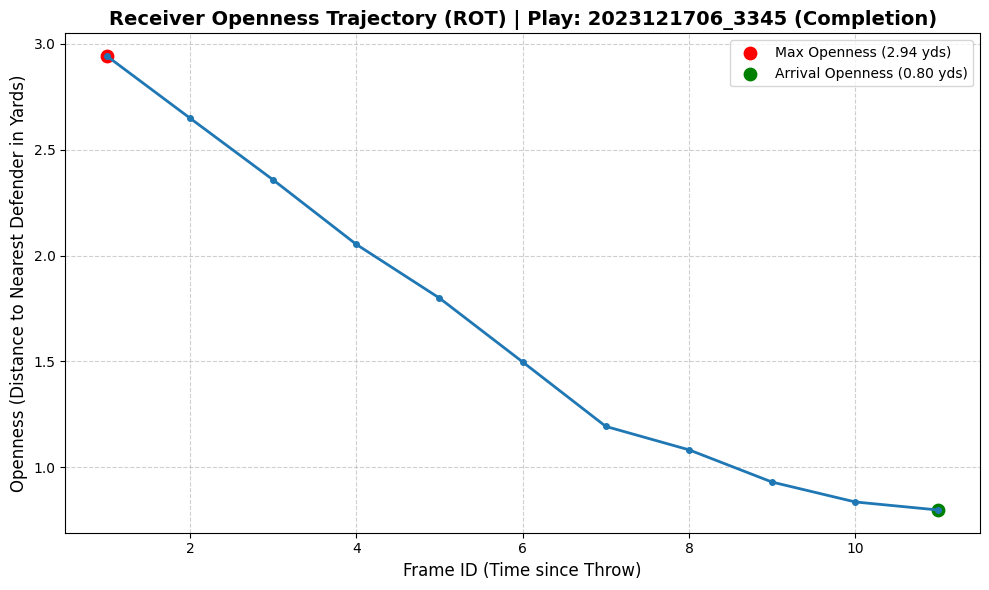


Plot generated successfully.


In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

def calculate_rot_and_plot(df: pd.DataFrame, receiver_role: str = 'Targeted Receiver', defender_role: str = 'Defensive Coverage'):
    """
    Calculates and plots the Receiver Openness Trajectory (ROT) for a randomly selected play.

    The ROT is the time-series of the minimum distance between the targeted
    receiver and any defensive player during the ball-in-air phase.

    Args:
        df (pd.DataFrame): The merged DataFrame containing player tracking data.
        receiver_role (str): The player_role value for the targeted receiver.
        defender_role (str): The player_role value for defensive coverage players.
    """
    if df.empty:
        print("Error: Input DataFrame is empty.")
        return

    # 1. Select a random play_id
    available_plays = df['game_play_id'].unique()
    if len(available_plays) == 0:
        print("Error: No unique game_play_id found in the data.")
        return

    selected_play_id = random.choice(available_plays)
    play_data = df[df['game_play_id'] == selected_play_id].copy()

    # Get the play result for the title
    pass_result = play_data['pass_result'].iloc[0] if not play_data.empty else 'N/A'
    result_map = {'C': 'Completion', 'I': 'Incompletion', 'IN': 'Interception', 'S': 'Sack', 'R': 'Scramble'}
    result_text = result_map.get(pass_result, 'Unknown Outcome')

    print(f"--- Analyzing Play ID: {selected_play_id} ({result_text}) ---")

    # 2. Filter for Receiver and Defenders
    receiver_data = play_data[play_data['player_role'] == receiver_role]
    defender_data = play_data[play_data['player_role'] == defender_role]

    if receiver_data.empty or defender_data.empty:
        print("Error: Targeted Receiver or Defensive Coverage data not found for this play.")
        return

    # Prepare for calculation
    openness_trajectory = []
    
    # Get the unique frame IDs (time steps)
    frames = receiver_data['frame_id'].unique()
    
    # 3. Calculate Minimum Distance (Openness) for each frame
    for frame in frames:
        # Receiver position at this frame
        rec_pos = receiver_data[receiver_data['frame_id'] == frame][['x', 'y']].values
        
        # Defender positions at this frame
        def_pos = defender_data[defender_data['frame_id'] == frame][['x', 'y']].values

        if rec_pos.size > 0 and def_pos.size > 0:
            rec_x, rec_y = rec_pos[0]
            
            # Calculate Euclidean distance from receiver to every defender
            distances = np.sqrt((def_pos[:, 0] - rec_x)**2 + (def_pos[:, 1] - rec_y)**2)
            
            # The openness is the minimum distance (to the nearest defender)
            min_distance = np.min(distances)
            
            openness_trajectory.append({
                'frame_id': frame,
                'min_distance': min_distance
            })
        else:
            # Handle case where a frame is missing (unlikely in BDB data, but good practice)
            openness_trajectory.append({'frame_id': frame, 'min_distance': np.nan})

    rot_df = pd.DataFrame(openness_trajectory).dropna()

    # 4. Plotting the Trajectory
    plt.figure(figsize=(10, 6))
    plt.plot(rot_df['frame_id'], rot_df['min_distance'], 
             marker='o', markersize=4, linestyle='-', color='#1f77b4', linewidth=2)

    # Calculate statistics for labeling
    max_openness = rot_df['min_distance'].max()
    min_openness = rot_df['min_distance'].min()
    
    # Highlight max and end points
    max_point = rot_df[rot_df['min_distance'] == max_openness].iloc[0]
    plt.scatter(max_point['frame_id'], max_point['min_distance'], color='red', s=80, label=f'Max Openness ({max_openness:.2f} yds)')
    
    end_point = rot_df.iloc[-1]
    plt.scatter(end_point['frame_id'], end_point['min_distance'], color='green', s=80, label=f'Arrival Openness ({end_point["min_distance"]:.2f} yds)')

    # Add descriptive labels and title
    plt.title(f'Receiver Openness Trajectory (ROT) | Play: {selected_play_id} ({result_text})', fontsize=14, fontweight='bold')
    plt.xlabel('Frame ID (Time since Throw)', fontsize=12)
    plt.ylabel('Openness (Distance to Nearest Defender in Yards)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("\nPlot generated successfully.")


for i in range(10):
    calculate_rot_and_plot(merged_with_sup, 
                       receiver_role='Targeted Receiver', 
                       defender_role='Defensive Coverage')

In [74]:
from typing import Dict, Any, List

def get_play_openness_metrics(play_data: pd.DataFrame, receiver_role: str, defender_role: str):
    """
    Calculates Max Openness, Arrival Openness, Openness Delta, and identifies the 
    nearest defender at the moment of arrival for a single play, including contextual data.
    """
    # Get common play context from the first row (assumed constant per play_id)
    first_row = play_data.iloc[0]
    
    metrics = {
        'game_play_id': first_row['game_play_id'],
        'nearest_defender_id': None,
        'openness_delta': np.nan,
        # Play Context
        'play_pass_result': first_row['pass_result'],
        'play_season': first_row['season'],
        'play_week': first_row['week'],
        'defensive_team': first_row['defensive_team'],
        # Defender Context (Placeholder until nearest defender is identified)
        'defender_name': None,
        'defender_position': None,
    }
    
    receiver_data = play_data[play_data['player_role'] == receiver_role]
    defender_data = play_data[play_data['player_role'] == defender_role]

    if receiver_data.empty or defender_data.empty or receiver_data.shape[0] < 2:
        return metrics # Not enough data for analysis

    openness_list = []
    
    # Calculate Openness Trajectory and track nearest defender for *last* frame
    final_frame = receiver_data['frame_id'].max()
    
    for frame in receiver_data['frame_id'].unique():
        rec_pos = receiver_data[receiver_data['frame_id'] == frame][['x', 'y']].values
        def_pos_df = defender_data[defender_data['frame_id'] == frame]
        
        if rec_pos.size > 0 and not def_pos_df.empty:
            rec_x, rec_y = rec_pos[0]
            
            distances = np.sqrt(
                (def_pos_df['x'].values - rec_x)**2 + 
                (def_pos_df['y'].values - rec_y)**2
            )
            
            min_distance = np.min(distances)
            openness_list.append(min_distance)

            # Check if this is the final frame (Arrival Openness)
            if frame == final_frame:
                nearest_defender_row = def_pos_df.iloc[np.argmin(distances)]
                
                metrics['nearest_defender_id'] = nearest_defender_row['nfl_id']
                metrics['defender_name'] = nearest_defender_row['player_name']
                metrics['defender_position'] = nearest_defender_row['player_position']

    if not openness_list:
        return metrics

    # Calculate Openness Metrics
    max_openness = np.max(openness_list)
    arrival_openness = openness_list[-1]
    
    metrics['openness_delta'] = max_openness - arrival_openness
    
    return metrics


def calculate_all_openness_deltas(df: pd.DataFrame, receiver_role: str = 'Targeted Receiver', defender_role: str = 'Defensive Coverage') -> pd.DataFrame:
    """
    Iterates through all plays in the DataFrame and calculates the Openness Delta
    and nearest defender for each play, returning all contextual data.

    Returns:
        pd.DataFrame: A DataFrame with one row per play containing all calculated 
                      and contextual metrics.
    """
    print("Starting calculation of Openness Delta for all plays...")
    unique_plays = df['game_play_id'].unique()
    all_metrics = []

    for play_id in unique_plays:
        play_data = df[df['game_play_id'] == play_id].copy()
        metrics = get_play_openness_metrics(play_data, receiver_role, defender_role)
        
        # Only include plays where a nearest defender was identified and delta calculated
        if metrics['nearest_defender_id'] is not None and not np.isnan(metrics['openness_delta']):
            all_metrics.append(metrics)

    if not all_metrics:
        print("No valid plays found for Openness Delta analysis.")
        return pd.DataFrame()

    print(f"Calculation complete. Processed {len(all_metrics)} plays.")
    return pd.DataFrame(all_metrics)


def plot_defender_openness_ranking(metrics_df: pd.DataFrame, groupby_cols: List[str] = ['nearest_defender_id', 'defender_name']):
    """
    Groups the calculated metrics by the specified columns and plots the top/bottom 10 ranked by 
    mean Openness Delta.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing metrics and contextual columns.
        groupby_cols (List[str]): Columns to group the data by before calculating the mean.
    """
    if metrics_df.empty:
        print("Metrics DataFrame is empty. Cannot generate ranking plot.")
        return
        
    # Create the y-axis labels based on the grouping
    if len(groupby_cols) > 1:
        # Create a combined label string for the plot if grouping by multiple columns
        metrics_df['plot_label'] = metrics_df[groupby_cols].apply(lambda row: ' | '.join(row.values.astype(str)), axis=1)
        label_col = 'plot_label'
    else:
        label_col = groupby_cols[0]

    # 1. Group by the provided columns and calculate mean Openness Delta
    defender_summary = metrics_df.groupby(groupby_cols)['openness_delta'].mean().reset_index()
    defender_summary.rename(columns={'openness_delta': 'mean_openness_delta'}, inplace=True)
    
    # 2. Prepare the plotting DataFrame
    # If grouping by multiple columns, merge the generated plot_label back in
    if len(groupby_cols) > 1:
        # Get one unique plot_label for each group combo
        label_map = metrics_df[[*groupby_cols, label_col]].drop_duplicates().set_index(groupby_cols)[label_col]
        # Map the label back onto the summary table
        defender_summary[label_col] = defender_summary.set_index(groupby_cols).index.map(label_map)
    
    # Filter out entries where the label is missing (should not happen with good data)
    plot_df_full = defender_summary.dropna(subset=[label_col])

    # 3. Select Top 10 (Best Closers) and Bottom 10 (Worst Closers)
    if plot_df_full.shape[0] < 20:
        print(f"Warning: Only {plot_df_full.shape[0]} unique groups found. Plotting all available.")
        N = plot_df_full.shape[0] // 2
        
        top_n = plot_df_full.sort_values(by='mean_openness_delta', ascending=False).head(N)
        bottom_n = plot_df_full.sort_values(by='mean_openness_delta', ascending=False).tail(N)
        plot_df = pd.concat([top_n, bottom_n]).drop_duplicates()
        
    else:
        # Best closers have the highest (most positive) delta
        top_10 = plot_df_full.sort_values(by='mean_openness_delta', ascending=False).head(10)
        # Worst closers have the lowest (least positive/most negative) delta
        bottom_10 = plot_df_full.sort_values(by='mean_openness_delta', ascending=False).tail(10)
        plot_df = pd.concat([top_10, bottom_10])


    plot_df['color'] = np.where(plot_df['mean_openness_delta'] > 0, '#38A169', '#E53E3E') # Green for positive, Red for negative

    # 4. Plotting the results
    plt.figure(figsize=(12, 8))
    # Sort for plotting clarity: best at the top, worst at the bottom
    plot_df = plot_df.sort_values(by='mean_openness_delta', ascending=True) 
    
    bars = plt.barh(plot_df[label_col], plot_df['mean_openness_delta'], color=plot_df['color'])
    
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    
    # Add labels to bars
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.1 if width > 0 else width - 0.7 
        plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
                 f'{width:.2f}', ha='center', va='center', 
                 color='black' if np.abs(width) > 0.1 else 'gray',
                 fontsize=9)
    
    plt.title(f'Top/Worst Closers by Mean Openness Delta Grouped by: {", ".join(groupby_cols)}', fontsize=14, fontweight='bold')
    plt.xlabel('Mean Openness Delta (Yards Closed After Peak)', fontsize=12)
    plt.ylabel('Grouping Key', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    print("\nDefender Closing Metrics plot generated successfully.")

In [71]:
all_play_metrics = calculate_all_openness_deltas(merged_with_sup, 
                                                 receiver_role='Targeted Receiver', 
                                                 defender_role='Defensive Coverage')

Starting calculation of Openness Delta for all plays...
Calculation complete. Processed 12966 plays.


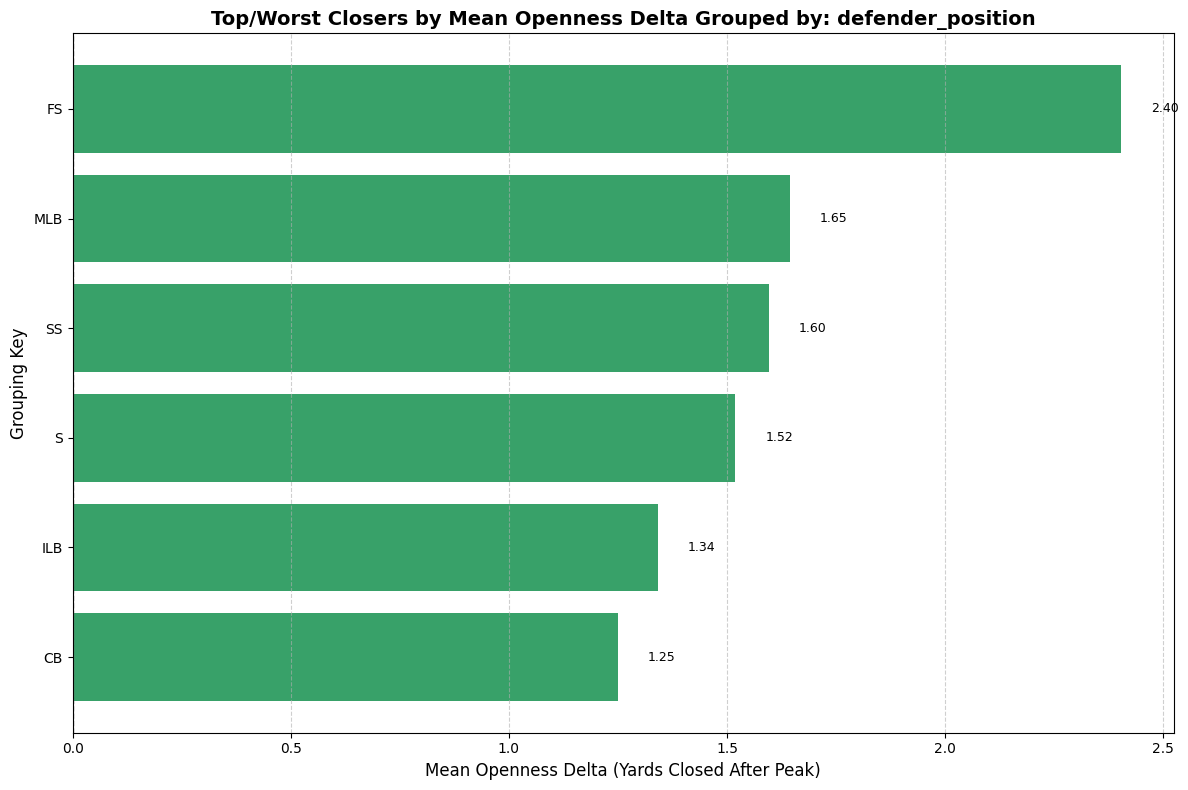


Defender Closing Metrics plot generated successfully.


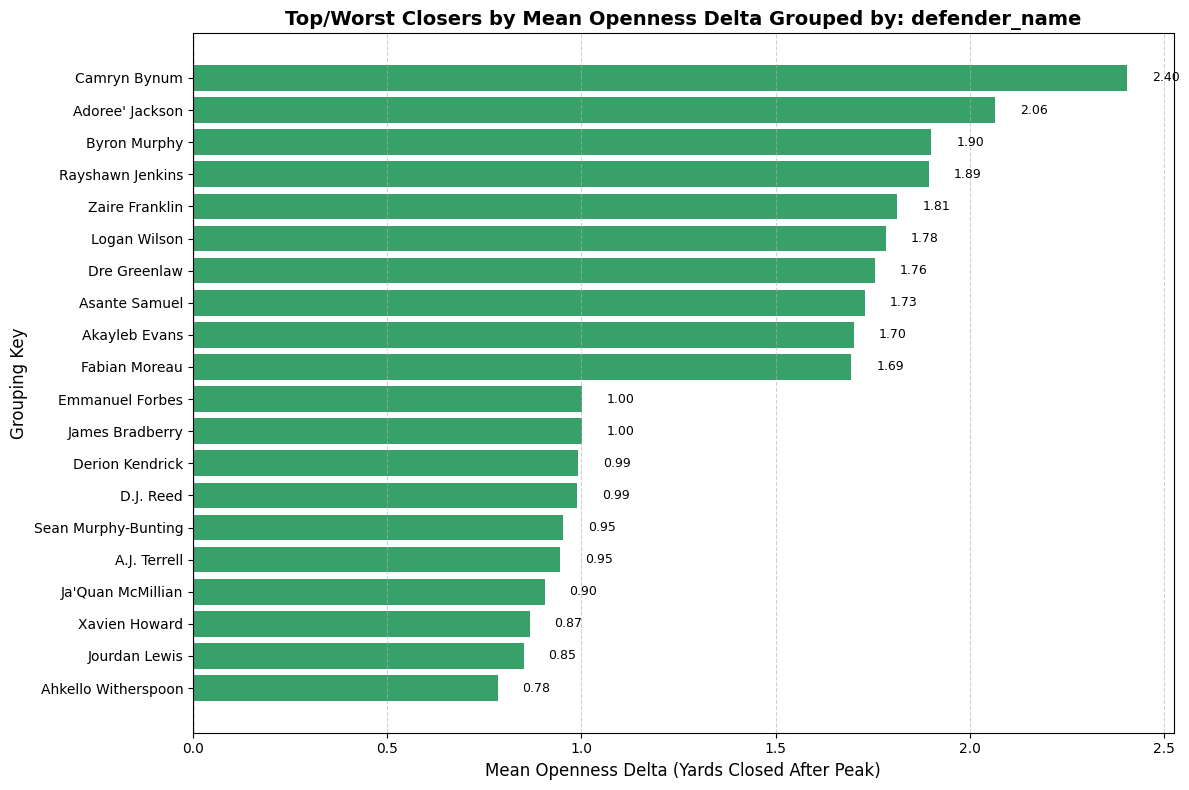


Defender Closing Metrics plot generated successfully.


In [79]:
all_play_metrics_50 = all_play_metrics[all_play_metrics['nearest_defender_id'].isin(all_play_metrics['nearest_defender_id'].value_counts()[all_play_metrics['nearest_defender_id'].value_counts() >= 50].index)]

plot_defender_openness_ranking(all_play_metrics_50, 
                               groupby_cols=['defender_position'])

plot_defender_openness_ranking(all_play_metrics_50, 
                               groupby_cols=['defender_name'])



In [80]:
all_play_metrics_50.sort_values(by='openness_delta', ascending=False)

,game_play_id,nearest_defender_id,openness_delta,play_pass_result,play_season,play_week,defensive_team,defender_name,defender_position
6832,2023111204_3537,47816,10.350117,C,2023,10,MIN,Byron Murphy,CB
5998,2023110500_3929,54486,10.253692,I,2023,9,KC,Trent McDuffie,CB
10158,2023121602_1743,44893,9.588499,I,2023,15,DEN,Fabian Moreau,CB
11826,2023123105_994,46304,8.286850,I,2023,17,IND,Zaire Franklin,MLB
10538,2023121708_2892,46456,7.957152,C,2023,15,JAX,Darious Williams,CB
...,...,...,...,...,...,...,...,...,...
9286,2023120700_1412,46775,0.000000,I,2023,14,NE,J.C. Jackson,CB
4124,2023101506_2433,44926,0.000000,C,2023,6,JAX,Rayshawn Jenkins,SS
9280,2023120700_943,52991,0.000000,C,2023,14,NE,Myles Bryant,S
9274,2023120700_542,37078,0.000000,I,2023,14,PIT,Patrick Peterson,CB
